In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, and_

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
# reflect the tables
Base = automap_base()
Base.prepare(autoload_with = engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [14]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

#Put date in list for future use in queries/calculations
date_list = [date for date in recent_date]
date_list

('2017-08-23',)


['2017-08-23']

2016-08-23


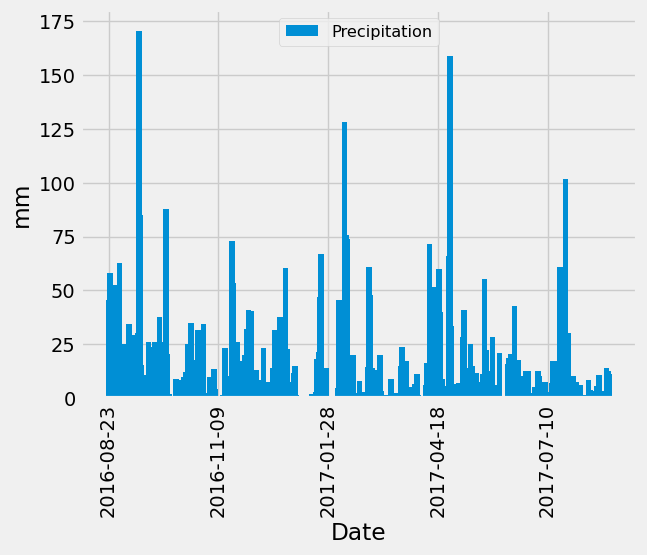

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.
for date in date_list:
    #format date ready for timedelta calc
    date_format = dt.datetime.strptime(date, "%Y-%m-%d").date()
    #timedelta calculation 
    last_year = date_format - dt.timedelta(days=365)
    print(last_year)

# Perform a query to retrieve the data and precipitation scores
results = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= last_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip = [{"Date": result[0], "Precipitation": result[1]} for result in results]

results_df = pd.DataFrame(precip)

# Sort the dataframe by date
results_df = results_df.sort_values("Date")
results_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
x_axis = results_df['Date']
y_axis = results_df["Precipitation"]

tick_locations = [0, 80, 160, 240, 320]
labels = ['2016-08-23', '2016-11-09', '2017-01-28', '2017-04-18', '2017-07-10']

plt.bar(x_axis, y_axis, width = 4)

plt.xlabel("Date")
plt.ylabel("mm")
plt.legend(["Precipitation"], loc=9, fontsize='small')

plt.xticks(tick_locations, labels=labels, rotation=90)

plt.ylim(0, max(results_df["Precipitation"])+10)

plt.show()

In [55]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary = results_df.describe()
summary

,Precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset


[(9,)]

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.


[(12.2, 29.4, 22.03582251082252)]

Text(0.5, 4.183333333333314, 'Temperature')

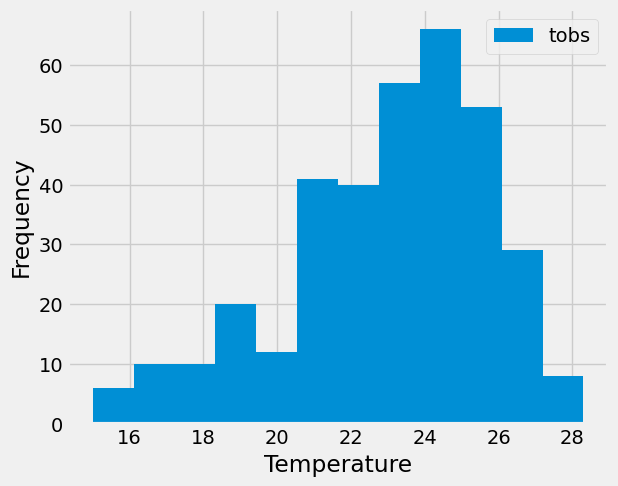

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close Session

In [16]:
# Close Session
session.close()